# Import

In [1]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline
#%tensorflow_version 1.x
#import tensorflow as tf
#print(tf.__version__)


## load dataset

In [2]:
dataset = pd.read_csv('SecundaIM.csv', sep =';', header=0, index_col=0)
values = dataset.values

In [3]:
dataset.describe()

,PM2.5,PM10,SO2,NO2,NO,NOx,O3,CO,Amb Wspeed,Amb WDirection,Temperature,Amb RelHum,Amb Pressure,Rain
count,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000
mean,29.171659,61.765095,7.242098,17.605830,9.686645,26.121403,29.554458,16.845333,1.881845,174.143041,15.839714,63.173814,848.373722,0.145777
std,45.125576,98.996429,9.881698,19.608876,16.521904,29.015767,24.132666,160.759570,1.387563,95.583791,7.438468,27.518155,11.924338,2.267876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.210000,0.000000,0.000000,0.000000
25%,8.525200,17.087900,2.005700,7.492000,2.433000,10.900000,13.522600,0.089000,0.830000,79.020000,12.200000,42.060000,845.580000,0.000000
50%,17.950000,37.304000,4.890000,13.717000,4.935000,19.317000,27.750124,0.233000,1.800000,175.316333,16.216102,63.986725,848.471099,0.000000
75%,31.456385,66.420114,7.737745,18.565700,9.878933,27.806900,37.361400,1.000000,2.440000,256.780000,20.220000,88.870000,851.240000,0.000000
max,1024.503000,4412.100000,306.293000,1009.120000,450.608000,490.957000,274.500000,5101.800000,11.950000,359.990000,40.360000,103.780000,879.000000,246.000000


## Plot pm2.5

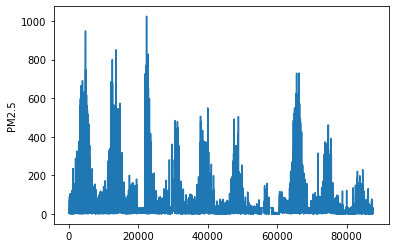

In [4]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [6]:
dataset.columns

Index(['PM2.5', 'PM10', 'SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'Amb Wspeed',
       'Amb WDirection', 'Temperature', 'Amb RelHum', 'Amb Pressure', 'Rain'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [7]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,]], axis=1, inplace=True)
values = reframed.values

## View the data

In [8]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.009341,0.002724,0.011100,0.002253,0.002730,0.005174,0.068915,0.000008,0.091213,0.590294,0.473337,0.963577,0.964391,0.0,0.004773
2,0.004773,0.001281,0.011264,0.002089,0.002375,0.005479,0.083653,0.000006,0.133054,0.354899,0.460366,0.963577,0.964130,0.0,0.010864
3,0.010864,0.002736,0.010219,0.009678,0.003573,0.016519,0.110260,0.000008,0.251883,0.194311,0.457896,0.914916,0.962036,0.0,0.008960
4,0.008960,0.002235,0.014398,0.008230,0.003173,0.020939,0.075195,0.000006,0.264435,0.164366,0.464072,0.853536,0.960557,0.0,0.006618
5,0.006618,0.001772,0.012472,0.007440,0.003262,0.014299,0.095053,0.000004,0.188285,0.205617,0.478279,0.785604,0.959420,0.0,0.008882


In [18]:
# split into train and test sets
values = reframed.values
train = values[:56092, :]
test = values[:14024, :]
val = values[:17530, :]
# split into input and outputs
train_X, train_Y = train[:, :-1], train[:, -1]
test_X, test_Y = test[:, :-1], test[:, -1]
val_X, val_Y = val[:, :-1], val[:, -1]
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape, val_X.shape, val_Y.shape)

(56092, 14) (56092,) (14024, 14) (14024,) (17530, 14) (17530,)


## Define a model

In [19]:
model = Sequential()
model.add(Dense(28, activation="relu", input_dim = 14))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mae', optimizer='adam',  metrics = ['accuracy'])

## Print summary

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 28)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 29        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


## Training

In [21]:
history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y),  epochs=30, batch_size=14,  verbose=1)

Epoch 1/30
4007/4007 [==============================] - 11s 3ms/step - loss: 0.0269 - accuracy: 2.4959e-04 - val_loss: 0.0195 - val_accuracy: 1.1409e-04
Epoch 2/30
4007/4007 [==============================] - 10s 2ms/step - loss: 0.0150 - accuracy: 2.4959e-04 - val_loss: 0.0177 - val_accuracy: 1.1409e-04
Epoch 3/30
4007/4007 [==============================] - 10s 2ms/step - loss: 0.0135 - accuracy: 2.4959e-04 - val_loss: 0.0161 - val_accuracy: 1.1409e-04
Epoch 4/30
4007/4007 [==============================] - 10s 2ms/step - loss: 0.0122 - accuracy: 2.4959e-04 - val_loss: 0.0153 - val_accuracy: 1.1409e-04
Epoch 5/30
4007/4007 [==============================] - 10s 2ms/step - loss: 0.0115 - accuracy: 2.4959e-04 - val_loss: 0.0147 - val_accuracy: 1.1409e-04
Epoch 6/30
4007/4007 [==============================] - 10s 3ms/step - loss: 0.0112 - accuracy: 2.4959e-04 - val_loss: 0.0146 - val_accuracy: 1.1409e-04
Epoch 7/30
4007/4007 [==============================] - 10s 2ms/step - loss: 0.011

## Plot the performance

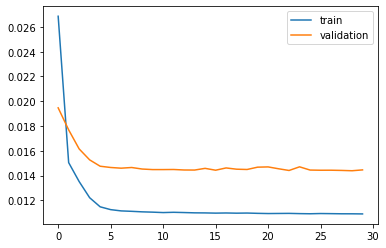

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Predict

In [24]:
prediction = model.predict(test_X)

439/439 [==============================] - 1s 2ms/step


In [25]:
from sklearn.metrics import r2_score 
print('R2 Score: ', r2_score(test_Y, prediction))

R2 Score:  0.5694310820834814


In [26]:
mean_squared_error(test_Y, prediction)

0.0016333474

In [31]:
# calculate RMSE
from math import sqrt 
rmse = sqrt(mean_squared_error(test_Y, prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.040


In [27]:
mean_absolute_error(test_Y, prediction)

0.015330454

In [28]:
print('accuracy testing = {}'.format(np.sum(prediction==test_Y)))

accuracy testing = 5


## Compare prediction and testing data

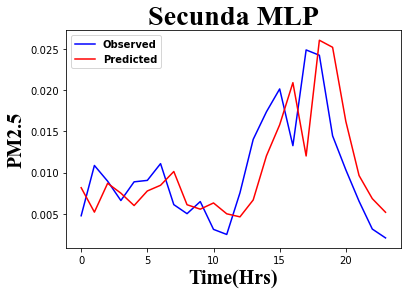

In [30]:
plt.plot(test_Y[0:24], color='blue', label = 'Observed')
plt.plot(prediction[0:24], color='red', label = 'Predicted')
plt.ylabel('PM2.5', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Secunda MLP', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

In [37]:
# make a persistence forecast
def persistence(last_ob, n_seq):
 return [last_ob for i in range(n_seq)]

In [38]:
# evaluate the persistence model
def make_forecasts(train, test, n_lag, n_seq):
 forecasts = list()
 for i in range(len(test)):
     X, y = test[i, 0:n_lag], test[i, n_lag:]
 # make forecast
 forecast = persistence(X[-1], n_seq)
 # store the forecast
 forecasts.append(forecast)
 return forecasts

In [39]:
forecasts = make_forecasts(train, test, 1, 14024)

In [40]:

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
 for i in range(n_seq):
     actual = test[:,(n_lag+i)]
 predicted = [forecast[i] for forecast in forecasts]
 rmse = sqrt(mean_squared_error(actual, predicted))
 print('t+%d RMSE: %f' % ((i+1), rmse))

In [43]:
evaluate_forecasts(test, forecasts, 1, 14024)

IndexError: index 15 is out of bounds for axis 1 with size 15

In [42]:

# plot the forecasts in the context of the original dataset
def plot_forecasts(reframed, forecasts, n_test):
 # plot the entire dataset in blue
 pyplot.plot(series.values)
 # plot the forecasts in red
 for i in range(len(forecasts)):
 off_s = len(series) - n_test + i
 off_e = off_s + len(forecasts[i])
 xaxis = [x for x in range(off_s, off_e)]
 pyplot.plot(xaxis, forecasts[i], color='red')
 # show the plot
 pyplot.show()

IndentationError: expected an indented block (Temp/ipykernel_5276/1052488247.py, line 7)

In [ ]:
# plot forecasts
plot_forecasts(series, forecasts, 12)

In [ ]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(reframed, forecasts, n_test):
 # plot the entire dataset in blue
 pyplot.plot(series.values)
 # plot the forecasts in red
 for i in range(len(forecasts)):
 off_s = len(series) - 12 + i - 1
 off_e = off_s + len(forecasts[i]) + 1
 xaxis = [x for x in range(off_s, off_e)]
 yaxis = [series.values[off_s]] + forecasts[i]
 pyplot.plot(xaxis, yaxis, color='red')
 # show the plot
 pyplot.show()

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))